# Sanity Check

In [1]:
random_seed=42

## Preparing data and black (In Orange framework, it is simple and good)

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

def f(x,y):
        return np.sin(10 * x) + np.cos(4 * y)  - np.cos(3*x*y) 

def predict(X):
    def f_binary(x):
        return int(1) if np.sin(10 * x[0]) + np.cos(4 * x[1])  - np.cos(3*x[0]*x[1]) >= 0 else int(0)
  
    X = np.array(X)
    if X.ndim == 1:
        y = f_binary(X)
    elif X.ndim==2:
        y = np.array(list(map(f_binary, X )) )
    else:
        print("error, blackbox function")
    return y

black_box= predict

prepare the dataset and the data encoder

In [3]:
%load_ext autoreload
%autoreload 2
from prepare_dataset import prepare_2d_sinusoidal_dataset
from utils import encoder_from_datatable


data_table = prepare_2d_sinusoidal_dataset(number=200)


from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data_table.X,data_table.Y,test_size=0.5,random_state=random_seed)

from Orange.data import Table
data_table = Table.from_numpy(X=X_train,Y=y_train,domain=data_table.domain)
test_data_table = Table.from_numpy(X=X_test,Y=y_test,domain=data_table.domain)

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# in this case the encoder is only a void passing, nothing is changed since 2-d dataset is simple two continuous variable

categorical_features_idx = [i for i,a in enumerate(data_table.domain.attributes) if a.is_discrete]

scikit_encoder = make_column_transformer(
                            ( OneHotEncoder(categories='auto'),categorical_features_idx),
                            remainder = 'passthrough'
                            )
scikit_encoder.fit(data_table.X)


black_box = lambda x:  predict(scikit_encoder.transform(x))


print("now start sanity-check")
print("the first row of the dataset is (orginal form):\n", data_table[0] )
print("the first row of the dataset is (only X data):\n", data_table.X[0])
print("the first row of the dataset is (transformed by the encoder, it should not change since the encoder is void):\n ",scikit_encoder.transform([data_table.X[0]] ))
print("the predition of blackbox on the first row:\n", black_box( [data_table.X[0]]  )   )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
now start sanity-check
the first row of the dataset is (orginal form):
 [0.075, 0.700 | no]
the first row of the dataset is (only X data):
 [0.075 0.7  ]
the first row of the dataset is (transformed by the encoder, it should not change since the encoder is void):
  [[0.07500000000000001 0.7000000000000001]]
the predition of blackbox on the first row:
 [0]


# Methods

run each implemented method one time. on the simple dataset



## Passive algorithm

###  Interpretable decision set

In [4]:
%load_ext autoreload
%autoreload 2
from competition_methods_explanation.passive_methods.ids import explain_tabular
iter_max = 1000
explanations = explain_tabular(data_table, black_box, target_class="yes", random_seed=42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
----------------------
If x-axis == 0.213 - 0.388, then 0.0
If x-axis == 0.213 - 0.388, then 1.0
If x-axis == 0.388 - 0.562, then 0.0
If x-axis == 0.388 - 0.562, then 1.0
If x-axis == 0.562 - 0.738, then 0.0
If x-axis == 0.562 - 0.738, then 1.0
If x-axis == ≥ 0.738, then 0.0
If x-axis == ≥ 0.738, then 1.0
If y-axis == 0.475 - 0.875, then 0.0
If y-axis == 0.475 - 0.875, then 1.0
If y-axis == 0.875 - 1.325, then 0.0
If y-axis == 0.875 - 1.325, then 1.0
If y-axis == < 0.475, then 0.0
If y-axis == < 0.475, then 1.0
If y-axis == ≥ 1.65, then 0.0
If y-axis == ≥ 1.65, then 1.0
2/n*n OPT value is 411.5546875
Estimating omega for rule 0
Standard Error 19.116197320597003
Omega estimate is -43.900000000001455
Estimating omega for rule 1
Standard Error 26.46856626264445
Omega estimate is 9.700000000004366
Estimating omega for rule 2
Standard Error 16.776680243719255
Omega estimate is 10.5
Estimating omega for r

KeyboardInterrupt: 

In [ ]:
from utils import  rule_to_string

for e in explanations:
    print(rule_to_string(e,data_table.domain,target_class_idx=1))

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

### BDS: bayesian decision set

In [ ]:
%load_ext autoreload
%autoreload 2
from competition_methods_explanation.passive_methods.brs import explain_tabular
iter_max = 1000
explanations = explain_tabular(data_table, black_box, target_class="yes", random_seed=42)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

### CN2 algorithm

In [ ]:
%load_ext autoreload
%autoreload 2
from competition_methods_explanation.passive_methods.cn2 import cn2_tabular
explanations = cn2_tabular(data_table,  black_box, target_class = "yes", random_seed=42)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

In [ ]:
r = output_rules[0]
r.selectors

data_table.domain.attributes[0].name

print(r)

### CN2-SD algorithm

In [ ]:
%load_ext autoreload
%autoreload 2
from competition_methods_explanation.passive_methods.cn2 import cn2sd_tabular
explanations = cn2sd_tabular(data_table, black_box, target_class = "yes", random_seed=42)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

## Bottom-up approaches

### CN2+Anchor

adopts the orignal implementation of anchor

In [ ]:
%load_ext autoreload
%autoreload 2
from competition_methods_explanation.active_methods_bottom_up.cn2anchor import cn2anchor_tabular
explanations = cn2anchor_tabular(data_table, black_box, target_class = "yes", random_seed=42)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

## Top-down approaches


It also demonstrates that, actively querying the blackbox, can really induce from the blackbox, some good descriptive patterns.


### DTExtract-Original (only continuous)

In [5]:
%load_ext autoreload
%autoreload 2
from competition_methods_explanation.active_methods_top_down.dt import explain_tabular
iter_max = 1000
explanations= explain_tabular(data_table,  black_box, target_class="yes", random_seed=42, termination_max=iter_max)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Fitting Gaussian mixture with 10 components...
Done!
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points


/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


Computed internal score: 0.7617809659163768
Computed leaf score: 0.5713357244372825
Internal node index: 0
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.8570035866559238
Computed leaf score: 0.33327917258841483
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points


/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


Computed internal score: 0.7617809659163768
Computed leaf score: 0.523724414067509
Current gain: 0.19044524147909425
Current score: 0.7617809659163768
Current size: 3
Internal node index: 1
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.7617809659163768
Computed leaf score: 0.6189470348070562
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.4285017933279619
Computed leaf score: 0.6665583451768297
Current gain: 0.523724414067509
Current score: 1.2855053799838858
Current size: 5
Internal node index: 2
Sampling 20 points
Done! Sampled 20 points
Generating int

/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)



Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.5713357244372825
Computed leaf score: 0.28566786221864127
Current gain: 0.23805655184886776
Current score: 1.5235619318327536
Current size: 7
Internal node index: 6
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.8093922762861503
Computed leaf score: 0.28566786221864127
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points


/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


Done! Sampled 20 test points
Computed internal score: 0.8093922762861503
Computed leaf score: 0.7141696555466032
Current gain: 0.28566786221864127
Current score: 1.8092297940513948
Current size: 9
Internal node index: 13
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.7617809659163768
Computed leaf score: 0.523724414067509
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points


/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


Done! Sampled 20 test points
Computed internal score: 0.8093922762861503
Computed leaf score: 0.523724414067509
Current gain: 0.523724414067509
Current score: 2.332954208118904
Current size: 11
Internal node index: 28
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.6665583451768297
Computed leaf score: 0.3808904829581884
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points


/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


Done! Sampled 20 test points
Computed internal score: 0.8093922762861503
Computed leaf score: 0.523724414067509
Current gain: 0.28566786221864127
Current score: 2.618622070337545
Current size: 13
Internal node index: 57
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.6189470348070562
Computed leaf score: 0.3808904829581884
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!


/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.6665583451768297
Computed leaf score: 0.4285017933279619
Current gain: 0.28566786221864127
Current score: 2.9042899325561864
Current size: 15
Internal node index: 58
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.6665583451768297
Computed leaf score: 0.23805655184886773
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points


/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


Done! Sampled 20 test points
Computed internal score: 0.523724414067509
Computed leaf score: 0.523724414067509
Current gain: 0.28566786221864127
Current score: 3.189957794774828
Current size: 17
Internal node index: 117
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.7617809659163768
Computed leaf score: 0.6189470348070562
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.7617809659163768
Computed leaf score: 0.6665583451768297
Current gain: 0.4285017933279619
Current score: 3.6184595881027897
Current size: 19
Internal node index: 115
Sampling 20 points
Done

/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.6665583451768297
Computed leaf score: 0.4285017933279619
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points


/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


Done! Sampled 20 test points
Computed internal score: 0.9046148970256973
Computed leaf score: 0.3808904829581884
Current gain: 0.23805655184886776
Current score: 3.8565161399516574
Current size: 21
Internal node index: 232
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.6189470348070562
Computed leaf score: 0.4285017933279619
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.6665583451768297
Computed leaf score: 0.4285017933279619
Current gain: 0.5237244140675089
Current score: 4.380240554019166
Current size: 23
Internal node index: 27
Sampling 20 points
Don

/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.8093922762861503
Computed leaf score: 0.6189470348070562
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.7617809659163768
Computed leaf score: 0.47611310369773546
Current gain: 0.23805655184886776
Current score: 4.856353657716902
Current size: 27
Internal node index: 934
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points

/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)



Computed internal score: 0.8093922762861503
Computed leaf score: 0.5713357244372825
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.8093922762861503
Computed leaf score: 0.5713357244372825
Current gain: 0.2856678622186413
Current score: 5.142021519935543
Current size: 29
Internal node index: 116
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Current mass: 0.9522262073954709
Sampling 20 test points
Done! Sampled 20 test points
Computed internal score: 0.7617809659163768
Computed leaf score: 0.6665583451768297
Sampling 20 points
Done! Sampled 20 points
Generating internal node with number of samples 20...
Done!
Generating leaf with number of samples 20...
Done!
Curre

/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/Users/lucy/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:297: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)


IF 0.0 <= y-axis <= 1.0860159993171692 THEN hit=yes 
IF 0.0 <= y-axis <= 1.0860159993171692 THEN hit=yes 
IF 0.0 <= y-axis <= 1.0860159993171692 AND 1.0860159993171692 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 1.1411309242248535 <= y-axis <= 1.0842593312263489 AND 1.1411309242248535 <= y-axis <= 1.0842593312263489 THEN hit=yes 
IF 1.1411309242248535 <= y-axis <= 1.0842593312263489 AND 1.1411309242248535 <= y-axis <= 1.0842593312263489 THEN hit=yes 
IF 1.0842593312263489 <= y-axis <= 1.2977166771888733 AND 1.0842593312263489 <= y-axis <= 1.2977166771888733 THEN hit=yes 
IF 1.3736247420310974 <= y-axis <= 1.2977166771888733 AND 1.3736247420310974 <= y-axis <= 1.2977166771888733 THEN hit=yes 
IF 1.1453442573547363 <= y-axis <= 1.2977166771888733 AND 1.1453442573547363 <= y-axis <= 1.2977166771888733 THEN hit=yes 
IF 1.2506234049797058 <= y-axis <= 1.2977166771888733 AND 1.2506234049797058 <= y-axis <= 1.2977166771888733 THEN hit=yes 
IF 1.2506234049797058 <= y-axis <= 1.29771667718

/Users/lucy/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


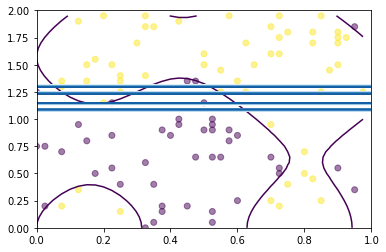

In [7]:
%matplotlib inline

from utils import  rule_to_string,ruleset_predict

for e in explanations:
    print(rule_to_string(e,data_table.domain,target_class_idx=1))
    
our_prediction = ruleset_predict(explanations,test_data_table.X)

print(sum(our_prediction) )
print(sum(test_data_table.Y) )

import sklearn
print('Blackbox and our, acc', sklearn.metrics.accuracy_score(test_data_table.Y, our_prediction))
print('Blackbox and our, f1 score', sklearn.metrics.f1_score(test_data_table.Y, our_prediction))
print('Blackbox and our,recall', sklearn.metrics.recall_score(test_data_table.Y, our_prediction))
print('Blackbox and our,precision', sklearn.metrics.precision_score(test_data_table.Y, our_prediction))


import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)

delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

### DTExtract-UCT (Our modified implementation)

We demonstrat by using a DTExtract algortithm (with a modification to utilize MCTS UCT to find node to split).


In [8]:
%load_ext autoreload
%autoreload 2
from competition_methods_explanation.active_methods_top_down.uct import explain_tabular
iter_max = 1000
explanations, tree = explain_tabular(
    data_table,  black_box, target_class="yes", random_seed=42, termination_max=iter_max)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
all space searched over
current termination count: 51


In [9]:
from utils import rule_to_string

for e in explanations:
    print(rule_to_string(e,data_table.domain,target_class_idx=1))

IF 0.7058080808080809 <= x-axis <= 0.9750000000000001 AND 1.1621212121212123 <= y-axis <= 1.7032904805632079 THEN hit=yes 
IF 0.325 <= x-axis <= 0.5519462299765331 AND 1.353122130394858 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.0 <= x-axis <= 0.25241502876948246 AND 0.0 <= y-axis <= 0.5051154334900892 THEN hit=yes 
IF 0.12584175084175087 <= x-axis <= 0.22651515151515153 AND 1.1621212121212123 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.43333333333333335 <= x-axis <= 0.9750000000000001 AND 0.9023665526155997 <= y-axis <= 1.1621212121212123 THEN hit=yes 
IF 0.6265459152281926 <= x-axis <= 0.7058080808080809 AND 1.1621212121212123 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.7028236914600552 <= x-axis <= 0.9750000000000001 AND 0.0 <= y-axis <= 0.2500066286971149 THEN hit=yes 
IF 0.0755101863789753 <= x-axis <= 0.12584175084175087 AND 1.1621212121212123 <= y-axis <= 1.9500000000000002 THEN hit=yes 
IF 0.7255050505050505 <= x-axis <= 0.9750000000000001 AND 0.2500066286

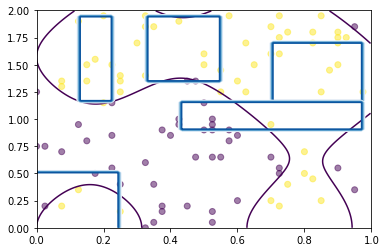

In [10]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
delta = 0.0025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations[0:5]
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# idx=1
# output_rule = output_rules[idx]

# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

#### we also show DTExtract-MCTS with no active query 

In [ ]:
%load_ext autoreload
%autoreload 2
from competition_methods_explanation.active_methods_top_down.uct import explain_tabular_no_query
K = -1
explanations, tree = explain_tabular_no_query(
    data_table, black_box, target_class="yes", K=K, random_seed=42, termination_max=10000000)

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations[:6]
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# idx=2
# output_rule = output_rules[idx]

# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


plt.title("run this on the labelled datasetonly without queriying")

plt.show()

## new

In [ ]:
%load_ext autoreload
%autoreload 2
from competition_methods_explanation.passive_methods.bds import explain_tabular
iter_max = 1000
explanations = explain_tabular(data_table, data_encoder, black_box, target_class="yes", random_seed=42)

In [ ]:
# [('y-axis_≥ 1.425',), ('x-axis_0.338 - 0.663_neg', 'x-axis_≥ 0.663')]

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2
from approach import explain_tabular
iter_max = 1000
explanations,ADS = explain_tabular(data_table, data_encoder, black_box, target_class="yes", random_seed=42,beta=0)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
# ax.scatter(ADS.synthetic_data_table.X[:,0], ADS.synthetic_data_table.X[:,1], c=ADS.synthetic_data_table.Y , alpha=0.5)


delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2
from approach import explain_tabular
iter_max = 1000
explanations,ADS = explain_tabular(data_table, data_encoder, black_box, target_class="yes", random_seed=42)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.ylim((0,2))
plt.xlim((0,1))

ax.scatter(data_table.X[:,0], data_table.X[:,1], c=data_table.Y , alpha=0.5)
# ax.scatter(ADS.synthetic_data_table.X[:,0], ADS.synthetic_data_table.X[:,1], c=ADS.synthetic_data_table.Y , alpha=0.5)


delta = 0.025
x = np.arange(0, 1, delta)
y = np.arange(0, 2, 2*delta)
X, Y = np.meshgrid(x, y)
F = f(X,Y)    
levels=[0]
fmt = {}
levels = [0] # the decision threshold is zero
CS = ax.contour(X, Y, F,levels=levels)
strs = ['']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, inline=0, fontsize=80,fmt=fmt)


# visualize the rule
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 100))
output_rules = explanations
for output_rule in output_rules:
    # Z = predict_by_rule(df_instances, output_rule)
    Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape).astype(int)
    CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)

# output_rule = output_rules[0]
# Z =  output_rule.evaluate_data(np.c_[xx.ravel(), yy.ravel()])

# Z = Z.reshape(xx.shape).astype(int)
# CS2 = ax.contour(xx, yy, Z, cmap=plt.cm.Blues)


# plt.title("CN2-Rules visualized value of the decision_function method")

plt.show()

In [ ]:
from random import sample 
  
# Prints list of random items of given length 
list1 = [1, 2, 3, 4, 5]  
  
print(sample(list1,1)[0]) 

In [ ]:
print( t.index('no') )

In [ ]:
i = np.where(data_table.Y == 1)[0]
print(i)
tmp = data_table[i]
print(tmp)
print(len(tmp))
print(len(i))


In [ ]:
print(data_table.domain)

In [ ]:
import Orange
d = Orange.statistics.basic.Domain(data_table)
print(d)

In [ ]:
import Orange
iris = Orange.data.Table("iris.tab")
disc = Orange.preprocess.Discretize()
disc.method = Orange.preprocess.discretize.EqualFreq(n=3)
d_iris = disc(iris)

In [ ]:
d_iris.domain.attributes[0].values

In [ ]:
a = [True,True]
print(np.sum(a))